In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime, timedelta

In [4]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper plus tools
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect, distinct, desc

In [6]:
#create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

      #Produce a declarative base for an existing schema
Base = automap_base()

    #reflect the schema/tables
Base.prepare(engine, reflect=True)

In [8]:
# View classes that automap found

Base.classes.keys()

['measurement', 'station']

In [9]:
# save table references 

measurement_table = Base.classes.measurement

station_table = Base.classes.station

# Create the inspector and connect it to the engine

inspector = inspect(engine)

# Print the column names and datatypes

print("Measurement Table\n")

columns_measurement_table = inspector.get_columns('measurement')

for column in columns_measurement_table:
    print(column["name"], column["type"])

print("\nStation Table\n")

columns_station_table = inspector.get_columns('station')

for column in columns_station_table:
    print(column["name"], column["type"])

Measurement Table

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create session (link from Python to the DB)

session = Session(bind=engine)

    # verify 

session.query(measurement_table.id).first()

(1)

# Exploratory Climate Analysis

In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

    # Calculate the date 1 year ago from the last data point in the database

newestdate_query = session.query(measurement_table.date).\
                                 order_by(measurement_table.date.desc()).first()

newest_date = datetime.strptime(newestdate_query[0], "%Y-%m-%d").date()


edge_date = newest_date - timedelta(days=365)

    # Perform a query to retrieve the data and precipitation scores
    
prec_query = session.query(measurement_table.date, measurement_table.prcp).\
               filter(measurement_table.date>=edge_date).\
               all()

    # Save the query results as a Pandas DataFrame and set the index to the date column
    
        #append data to lists
        
date =[]
prec_data =[]

for record in prec_query:
    date.append(record[0])
    prec_data.append(record[1])
    
            #combine lists into dataframe
        
prec_df = pd.DataFrame((zip(date, prec_data)), 
               columns =[ 'date', 'precipitation']) 

            #drop NaNs
prec_df.dropna(inplace=True)

    # Sort the dataframe by date
prec_df.sort_values('date', ascending=False)

            #set index
prec_df.set_index('date', inplace=True)

prec_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


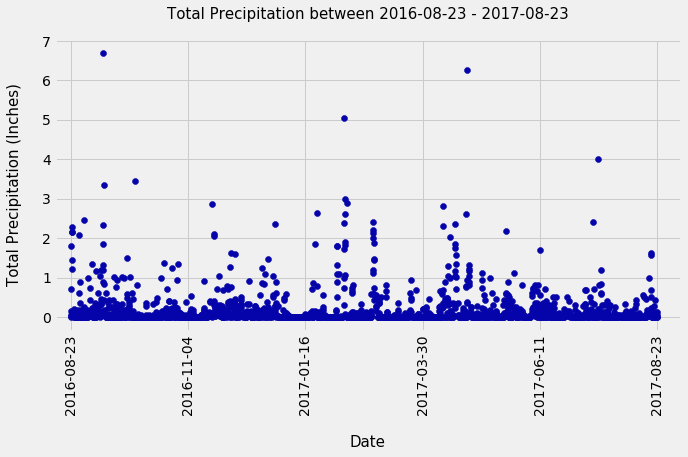

In [151]:
# plot findings

    #setup
plt.figure(figsize=(10, 5))

labels = [edge_date,
         newest_date - timedelta(days=365*4/5), 
         newest_date - timedelta(days=365*3/5), 
         newest_date - timedelta(days=365*2/5),
         newest_date - timedelta(days=365*1/5),
         newest_date]

    #plot
plt.scatter(prec_df.index,
            prec_df["precipitation"],
            color='#0504aa')

plt.xticks(np.arange(0, 370, 365/5), labels, rotation=90)

plt.xlim(-10, 380)
plt.ylabel('Total Precipitation (Inches)',fontsize=15, labelpad=20)
plt.xlabel('Date',fontsize=15, labelpad=20)


plt.title(f'Total Precipitation between {edge_date} and {newest_date}',fontsize=15, pad=20)

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data

print("Precipitation - Summary statistics")

prec_df.describe()

Precipitation - Summary statistics


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
#station_count = 

print(f'number of stations: {session.query(distinct(station_table.id)).count()}')

number of stations: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
    # List the stations and the counts in descending order.

    #query
station_activity = session.query(measurement_table.station,
                                 func.count(measurement_table.station)).\
                           group_by(measurement_table.station).\
                           order_by(desc(func.count(measurement_table.station))).all()

    #into dataframe
station_activity_df = pd.DataFrame({"Station Id" : [record[0] for record in station_activity],
                                    "Activity Count" :[record[1] for record in station_activity]})

print("Number of Observations by Station\n")
station_activity_df

Number of Observations by Station



,Station Id,Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

    #id of most active
most_active = session.query(measurement_table.station,
                          func.count(measurement_table.station)).\
                          group_by(measurement_table.station).\
                          order_by((func.count(measurement_table.station).desc())).\
                          first()

    #query min, max and avg temp
output = session.query(func.min(measurement_table.tobs),
                        func.max(measurement_table.tobs),
                        func.avg(measurement_table.tobs)).\
                   filter(measurement_table.station == most_active[0]).all()     



stats_most_active_station = pd.DataFrame(output, columns= ["min", "max", "avg"])
                                                         

print("Most Active Station - Summary Temperature Statistics")

stats_most_active_station

Most Active Station - Summary Temperature Statistics


,min,max,avg
0,54.0,85.0,71.663781


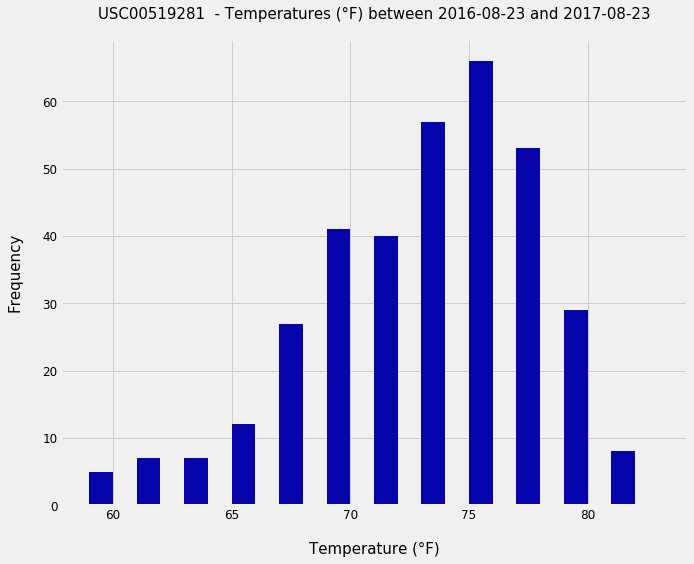

In [152]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

    #id of most temp obs
most_temp_obs= session.query(measurement_table.station,
                            func.count(measurement_table.tobs)).\
                      group_by(measurement_table.station).\
                      order_by(desc(func.count(measurement_table.tobs))).first()
    #query
most_temp_obs_and_last_year_data = session.query(measurement_table.tobs).\
                                           filter(measurement_table.station == most_temp_obs[0]).\
                                           filter(measurement_table.date>=edge_date).\
                                           all()  

    #create list

temp_data = []

for record in most_temp_obs_and_last_year_data:
    temp_data.append(record[0])
    
temp_data

    #plot histogram
    
plt.figure(figsize=[10,8])

plt.hist(temp_data, bins=12, width = 1, color='#0504aa')
plt.xlabel('Temperature (\N{DEGREE SIGN}F)',fontsize=15, labelpad=20)
plt.ylabel('Frequency',fontsize=15, labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'{most_temp_obs[0]}  - Temperatures (\N{DEGREE SIGN}F) between {edge_date} and {newest_date}',fontsize=15, pad=20)
plt.show()

## Bonus Challenge Assignment

Temperature Analysis I
---

* The average temperature in June (73.68 F) is signifigantly higher than the average temperture in December (71.04 F).

In [18]:
#Identify the average temperature in June and December at all stations across all available years in the dataset

    #create function to find 
    
june_temp_obs = session.query(measurement_table.tobs).\
                        filter(func.strftime("%m", measurement_table.date) == "05").all()

dec_temp_obs = session.query(measurement_table.tobs).\
                           filter(func.strftime("%m", measurement_table.date) == "12").all()

print(f'Mean June Temp: {round(np.mean(june_temp_obs),2)}')

print(f'Mean December Temp: {round(np.mean(dec_temp_obs),2)}')

Mean June Temp: 73.68
Mean December Temp: 71.04


In [19]:
    #look at summary stats
        #June
stats.describe(june_temp_obs)

DescribeResult(nobs=1733, minmax=(array([63.]), array([87.])), mean=array([73.68090017]), variance=array([11.26128048]), skewness=array([-0.29038381]), kurtosis=array([-0.17598489]))

In [20]:
    #December
stats.describe(dec_temp_obs)

DescribeResult(nobs=1517, minmax=(array([56.]), array([83.])), mean=array([71.04152933]), variance=array([14.03191534]), skewness=array([-0.4050973]), kurtosis=array([0.45781716]))

In [21]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant

stats.ttest_ind(june_temp_obs, dec_temp_obs, equal_var = False)

Ttest_indResult(statistic=array([21.03239802]), pvalue=array([7.45465609e-92]))

Temperature Analysis II
---

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement_table.tobs), 
                         func.avg(measurement_table.tobs), 
                         func.max(measurement_table.tobs)).\
        filter(measurement_table.date >= start_date).filter(measurement_table.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for the trip using the previous year's data for those same dates.

start_date = "2017-05-07"

end_date = "2017-05-26"

temp_stats = pd.DataFrame(calc_temps(start_date, end_date), 
                                         columns= ["min", "avg", "max"])
                                                         
print("Summary Temperature Statistics")

temp_stats

Summary Temperature Statistics


,min,avg,max
0,66.0,74.765766,87.0


[]

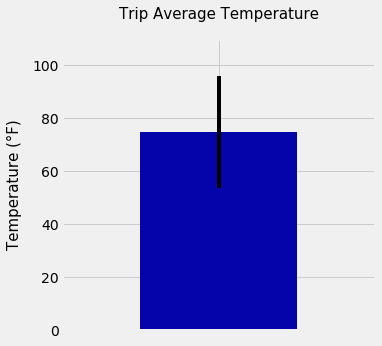

In [24]:
# Plot the results from your previous query as a bar chart. 
    # Use the average temperature for the y value
    # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ax = temp_stats.plot(y="avg", x=None, 
                     kind="bar", 
                     yerr=[temp_stats["min"] - temp_stats["max"]],
                     figsize=(5,5),
                     legend=False,
                     ylim=(0, 110),
                     color='#0504aa',
                     xticks=None)

ax.set_ylabel("Temperature (\N{DEGREE SIGN}F)", fontsize=15, labelpad=10)
ax.set_title("Trip Average Temperature", fontsize=15, pad=20)
ax.set_xticklabels("")

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

 #query - precipitation amount and station (name, latitude, longitude, and elevation)

sel = [measurement_table.station,
        station_table.name, 
        func.sum(measurement_table.prcp), 
        station_table.latitude,
        station_table.longitude,
        station_table.elevation]

station_prec_sum = session.query(*sel).\
                           group_by(measurement_table.station).\
                           filter(measurement_table.date >= start_date).\
                           filter(measurement_table.date <= end_date).\
                           filter(measurement_table.station==station_table.station).\
                           order_by(desc(func.sum(measurement_table.prcp))).all()
   

In [26]:
 #into dataframe
station_prec_sum_df = pd.DataFrame({"Station Id" : [record[0] for record in station_prec_sum],
                                    "Station Name" : [record[1] for record in station_prec_sum],
                                    "Total Precipitation" : [record[2] for record in station_prec_sum],
                                    "Station Latitude" : [record[3] for record in station_prec_sum],
                                    "Station Longitude" : [record[4] for record in station_prec_sum],
                                    "Station Elevation" : [record[5] for record in station_prec_sum]
                                   })

    #display findings     
print("Total Precipitation by Station\n")
                                   
station_prec_sum_df.set_index("Station Id", inplace=True)

station_prec_sum_df

Total Precipitation by Station



,Station Name,Total Precipitation,Station Latitude,Station Longitude,Station Elevation
Station Id,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",8.31,21.33310,-157.80250,152.4
USC00519281,"WAIHEE 837.5, HI US",3.94,21.45167,-157.84889,32.9
USC00513117,"KANEOHE 838.1, HI US",3.33,21.42340,-157.80150,14.6
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.42,21.33556,-157.71139,19.5
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.98,21.52130,-157.83740,7.0
USC00519397,"WAIKIKI 717.2, HI US",0.44,21.27160,-157.81680,3.0


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement_table.tobs), func.avg(measurement_table.tobs), func.max(measurement_table.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement_table.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip

start = datetime.strptime(start_date, "%Y-%m-%d")

end = datetime.strptime(end_date, "%Y-%m-%d")

    # Use the start and end date to create a range of dates
date_list = [end - timedelta(days=x) for x in range(26)]

    # Strip off the year and save a list of %m-%d strings
date_list_string_format = []

for date in date_list:
     date_list_string_format.append(date.strftime("%m-%d"))

    # Loop through the list of %m-%d strings and calculate the normals for each date and 
    # push each tuple of calculations into a list called `normals`

normals = []
    
for date in date_list_string_format:
    normals.append(daily_normals(date))

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame({"Date" : date_list,
                           "tmin" : [record[0][0] for record in normals],
                           "tavg" : [record[0][1] for record in normals],
                           "tmax" : [record[0][2] for record in normals]
                                   })

labels = normals_df["Date"].tolist()

normals_df.set_index("Date", inplace=True)

normals_df

,tmin,tavg,tmax
Date,,,
2017-05-26,65.0,74.036364,82.0
2017-05-25,68.0,74.275862,79.0
2017-05-24,67.0,73.948276,79.0
2017-05-23,68.0,74.948276,87.0
2017-05-22,64.0,74.456140,80.0
2017-05-21,64.0,72.964286,80.0
2017-05-20,68.0,73.896552,79.0
2017-05-19,65.0,73.807018,79.0
2017-05-18,68.0,74.107143,82.0


(45, 90)

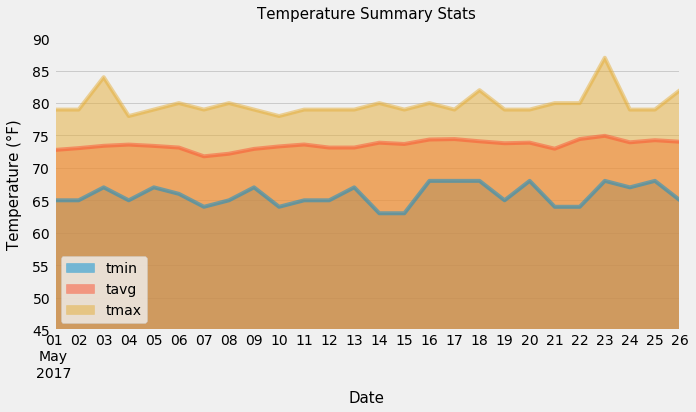

In [30]:
# Plot the daily normals as an area plot 

ax = normals_df.plot.area(stacked=False, figsize=(10,5), legend="lower-right")

ax.set_ylabel("Temperature (\N{DEGREE SIGN}F)", fontsize=15, labelpad=10)
ax.set_xlabel("Date", fontsize=15, labelpad=10)
ax.set_title("Temperature Summary Stats", fontsize=15, pad=20)
ax.set_ylim(45, 90)